In [136]:
import numpy as np
import xarray as xr

import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib.colors import LogNorm
%matplotlib inline


import os
import shutil
import glob
# import xrft

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

from matplotlib.tri import Triangulation
from mpas_tools.viz import mesh_to_triangles
from mpas_tools.ocean import depth
from mpas_tools.viz import colormaps

In [137]:
%%time
grid = xr.open_dataset('/global/cfs/cdirs/e3sm/inputdata/ocn/mpas-o/EC30to60E2r2/ocean.EC30to60E2r2.200908.nc')

CPU times: user 10.6 s, sys: 985 ms, total: 11.6 s
Wall time: 11.7 s


In [138]:
grid

<xarray.Dataset>
Dimensions:                        (Time: 1, nCells: 236853, nEdges: 719506,
                                    nVertices: 482371, maxEdges: 7, TWO: 2,
                                    vertexDegree: 3, maxEdges2: 14,
                                    nForcingGroupsMax: 4, nVertLevels: 60,
                                    nVertLevelsP1: 61)
Dimensions without coordinates: Time, nCells, nEdges, nVertices, maxEdges, TWO,
                                vertexDegree, maxEdges2, nForcingGroupsMax,
                                nVertLevels, nVertLevelsP1
Data variables: (12/64)
    SSHGradientMeridional          (Time, nCells) float64 ...
    SSHGradientZonal               (Time, nCells) float64 ...
    angleEdge                      (nEdges) float64 ...
    areaCell                       (nCells) float64 ...
    areaTriangle                   (nVertices) float64 ...
    atmosphericPressure            (Time, nCells) float64 ...
    ...                             ...
    yCell                          (nCells) float64 ...
    yEdge                          (nEdges) float64 ...
    yVertex                        (nVertices) float64 ...
    zCell                          (nCells) float64 ...
    zEdge                          (nEdges) float64 ...
    zVertex                        (nVertices) float64 ...
Attributes: (12/1174)
    model_name:                                                      mpas
    core_name:                                                       ocean
    source:                                                          MPAS
    Conventions:                                                     MPAS
    git_version:                                                     v7.0-111...
    on_a_sphere:                                                     YES
    ...                                                              ...
    MPAS_Mesh_MPAS-Tools_Version:                                    0.0.12
    MPAS_Mesh_NCO_Version:                                           4.9.3
    MPAS_Mesh_ESMF_Version:                                          8.0.1
    MPAS_Mesh_geometric_features_Version:                            0.1.11
    MPAS_Mesh_Metis_Version:                                         5.1.0
    MPAS_Mesh_pyremap_Version:                                       0.0.7

In [139]:
lat = grid.latCell.values
lon = grid.lonCell.values

latdeg = np.degrees(lat)
londeg = np.degrees(lon)

zbot = grid.refBottomDepth.values
ztop = np.zeros(len(zbot)+1)
ztop[1:] = zbot
zmid = -0.5*(ztop[:-1]+zbot)
zt = ztop[:-1]

latmin = np.deg2rad(20)
latmax = np.deg2rad(40)
lonmin = np.deg2rad(290)
lonmax = np.deg2rad(310)
indsLR = np.where((lon>lonmin)&(lon<lonmax)&(lat>latmin)&(lat<latmax))[0]

In [141]:
%%time

nCells = grid.nCells.values
conc = grid.cellsOnCell.values-1

cdfac1 = [[] for _ in range(len(nCells))]
cdfac2 = [[] for _ in range(len(nCells))]
cdfac3 = [[] for _ in range(len(nCells))]

def list_cells_on_a_cell(idx):
    a = list(conc[idx][conc[idx]>-1])
    b = nCells[idx]
    a.append(b)
    return list(set(a))

def list_cells_on_cells(list_cells):
    temp = []
    for j in list_cells:
        temp+=list_cells_on_a_cell(j)
    return list(set(temp))
        
        
for i in nCells:
    
    cdfac1[i] = list_cells_on_a_cell(i)
    cdfac2[i] = list_cells_on_cells(cdfac1[i])
    cdfac3[i] = list_cells_on_cells(cdfac2[i])


CPU times: user 59.3 s, sys: 1.48 s, total: 1min
Wall time: 1min


In [146]:
%%time
number_of_dilations=6
nCells = grid.nCells.values
conc = grid.cellsOnCell.values-1
cdfac = {}
for ij in range(number_of_dilations):
    cdfac[ij] = [[] for _ in range(len(nCells))]

def list_cells_on_a_cell(idx):
    a = list(conc[idx][conc[idx]>-1])
    b = nCells[idx]
    a.append(b)
    return list(set(a))

def list_cells_on_cells(list_cells):
    temp = []
    for j in list_cells:
        temp+=list_cells_on_a_cell(j)
    return list(set(temp))
        
        
for i in nCells:
    for ij in range(number_of_dilations):
        if ij == 0 :
            cdfac[ij][i] = list_cells_on_a_cell(i)
        else:
            cdfac[ij][i] = list_cells_on_cells(cdfac[ij-1][i])



CPU times: user 6min 24s, sys: 1.79 s, total: 6min 26s
Wall time: 6min 26s


In [147]:
areacell = grid.areaCell.values

for i in range(number_of_dilations):
    print(areacell[153449], areacell[cdfac[i][153449]].sum())

904378986.1511115 6567744755.932184
904378986.1511115 17012029814.946379
904378986.1511115 32500344723.687584
904378986.1511115 53390481352.192406
904378986.1511115 79135565500.74399
904378986.1511115 109707189811.34532


In [148]:
areacell = grid.areaCell.values

for i in range(number_of_dilations):
    print(np.sqrt(areacell[153449])/1e3, np.sqrt(areacell[cdfac[i][153449]].sum())/1e3)

30.072894542280288 81.04162360128394
30.072894542280288 130.43017218016075
30.072894542280288 180.27851986214992
30.072894542280288 231.0638036391516
30.072894542280288 281.3104432841838
30.072894542280288 331.2207569149997


In [149]:
grid

<xarray.Dataset>
Dimensions:                        (Time: 1, nCells: 236853, nEdges: 719506,
                                    nVertices: 482371, maxEdges: 7, TWO: 2,
                                    vertexDegree: 3, maxEdges2: 14,
                                    nForcingGroupsMax: 4, nVertLevels: 60,
                                    nVertLevelsP1: 61)
Dimensions without coordinates: Time, nCells, nEdges, nVertices, maxEdges, TWO,
                                vertexDegree, maxEdges2, nForcingGroupsMax,
                                nVertLevels, nVertLevelsP1
Data variables: (12/64)
    SSHGradientMeridional          (Time, nCells) float64 ...
    SSHGradientZonal               (Time, nCells) float64 ...
    angleEdge                      (nEdges) float64 ...
    areaCell                       (nCells) float64 9.526e+08 ... 8.633e+08
    areaTriangle                   (nVertices) float64 ...
    atmosphericPressure            (Time, nCells) float64 ...
    ...                             ...
    yCell                          (nCells) float64 ...
    yEdge                          (nEdges) float64 ...
    yVertex                        (nVertices) float64 ...
    zCell                          (nCells) float64 ...
    zEdge                          (nEdges) float64 ...
    zVertex                        (nVertices) float64 ...
Attributes: (12/1174)
    model_name:                                                      mpas
    core_name:                                                       ocean
    source:                                                          MPAS
    Conventions:                                                     MPAS
    git_version:                                                     v7.0-111...
    on_a_sphere:                                                     YES
    ...                                                              ...
    MPAS_Mesh_MPAS-Tools_Version:                                    0.0.12
    MPAS_Mesh_NCO_Version:                                           4.9.3
    MPAS_Mesh_ESMF_Version:                                          8.0.1
    MPAS_Mesh_geometric_features_Version:                            0.1.11
    MPAS_Mesh_Metis_Version:                                         5.1.0
    MPAS_Mesh_pyremap_Version:                                       0.0.7

In [155]:

indsLR2 = np.where((lon>np.deg2rad(298))&(lon<np.deg2rad(302))&(lat>np.deg2rad(28))&(lat<np.deg2rad(32)))[0]
indsLR2

array([  4698,   4708,   4709,   4710,   4711,   4712,   4713,   4715,
         4717,   4719,   5865,   6205,  23883,  24142,  46548,  49846,
        49847,  51975,  51976,  52368,  52764,  52904,  58501,  71871,
        71872,  84054,  85315,  88747,  88748,  93496,  96374,  96756,
       107209, 109968, 109969, 111479, 116579, 125747, 127336, 130169,
       130990, 134880, 140103, 144422, 145653, 147253, 148862, 158825,
       163077, 165242, 170549, 173710, 176843, 177875, 182137, 202643,
       204039, 209604])

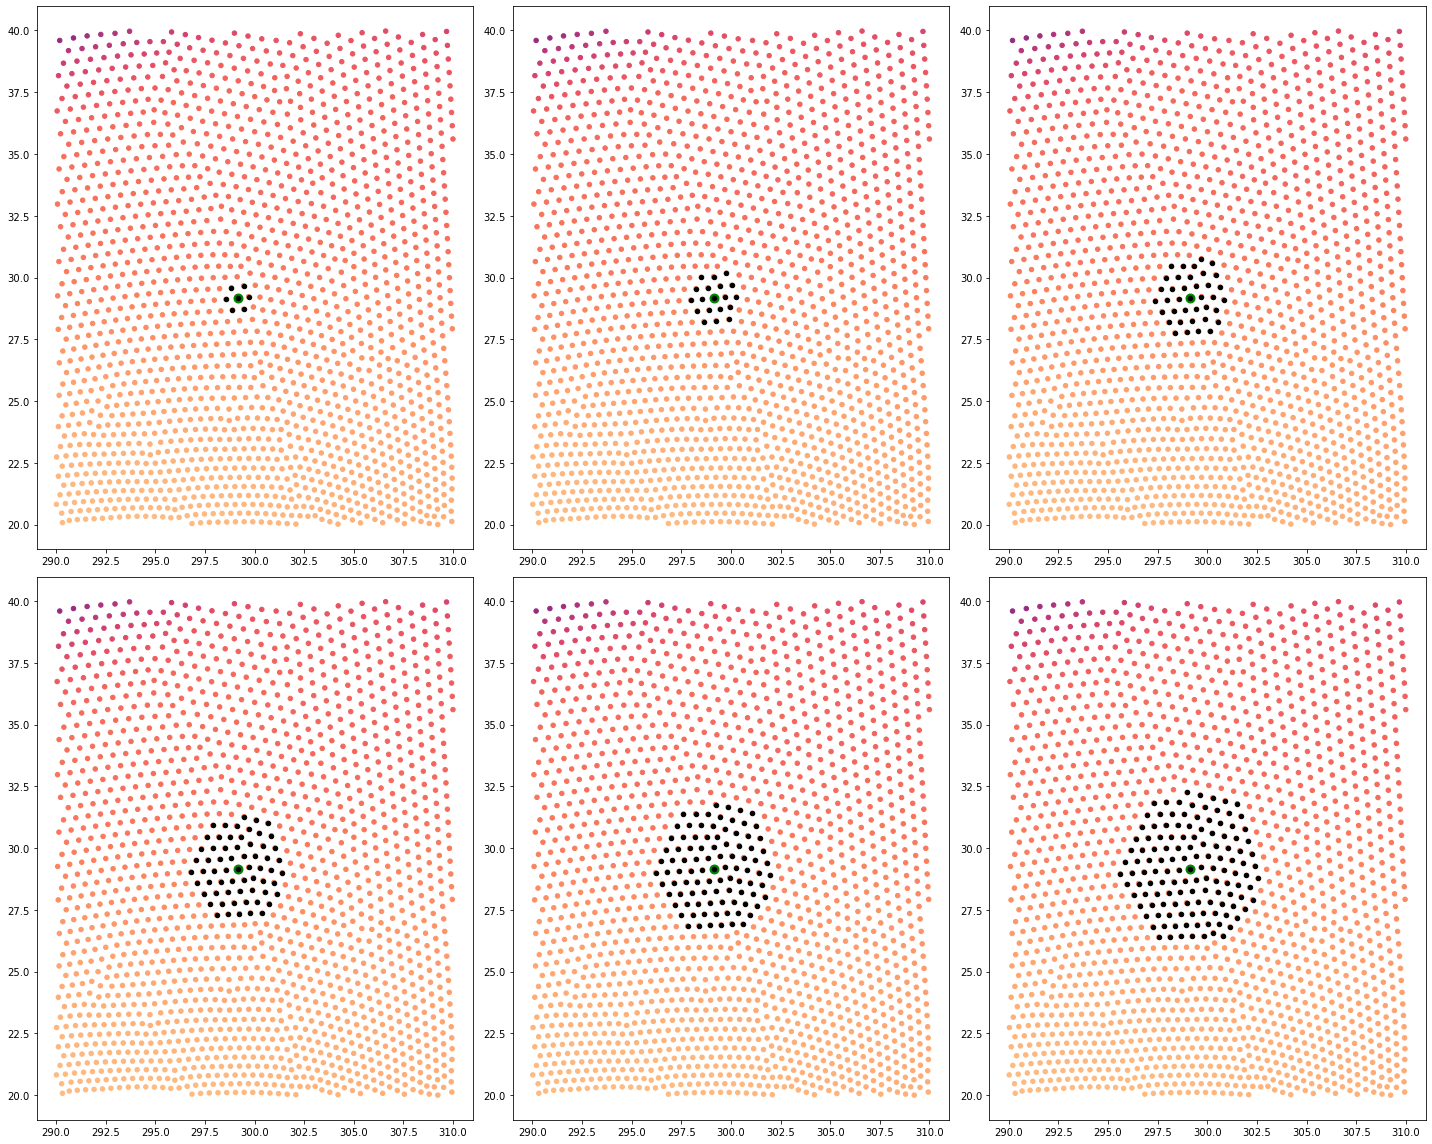

In [163]:
plt.figure(figsize=(20,16), tight_layout=True)


for i in range(number_of_dilations):
    plt.subplot(2,3,i+1)
    plt.scatter(londeg[indsLR],latdeg[indsLR],
                s=20,
                c=grid['temperature'][0,indsLR,0],
                cmap='magma',
                vmin=-5, vmax=31
               )
    plt.scatter(londeg[88747], latdeg[88747], c = 'g', s=80)
    plt.scatter(londeg[cdfac[i][88747]], latdeg[cdfac[i][88747]], c = 'k', s=20)
    

In [164]:
%%time
number_of_dilations=8

nCells = grid.nCells.values
conc = grid.cellsOnCell.values-1
cdfac = {}
for ij in range(number_of_dilations):
    cdfac[ij] = [[] for _ in range(len(nCells))]

def list_cells_on_a_cell(idx):
    a = list(conc[idx][conc[idx]>-1])
    b = nCells[idx]
    a.append(b)
    return list(set(a))

def list_cells_on_cells(list_cells):
    temp = []
    for j in list_cells:
        temp+=list_cells_on_a_cell(j)
    return list(set(temp))
        
        
for i in nCells:
    for ij in range(number_of_dilations):
        if ij == 0 :
            cdfac[ij][i] = list_cells_on_a_cell(i)
        else:
            cdfac[ij][i] = list_cells_on_cells(cdfac[ij-1][i])




CPU times: user 21min 23s, sys: 11.7 s, total: 21min 35s
Wall time: 21min 33s


In [171]:
areacell = grid.areaCell.values

for i in range(number_of_dilations):
    print(areacell[153449]/1e6, areacell[cdfac[i][153449]].sum()/1e6)

904.3789861511115 6567.7447559321845
904.3789861511115 17012.029814946378
904.3789861511115 32500.344723687584
904.3789861511115 53390.48135219241
904.3789861511115 79135.565500744
904.3789861511115 109707.18981134532
904.3789861511115 145201.04469698726
904.3789861511115 185811.84073311547


In [165]:
areacell = grid.areaCell.values

for i in range(number_of_dilations):
    print(np.sqrt(areacell[153449])/1e3, np.sqrt(areacell[cdfac[i][153449]].sum())/1e3)

30.072894542280288 81.04162360128394
30.072894542280288 130.43017218016075
30.072894542280288 180.27851986214992
30.072894542280288 231.0638036391516
30.072894542280288 281.3104432841838
30.072894542280288 331.2207569149997
30.072894542280288 381.0525484719755
30.072894542280288 431.0589759338222


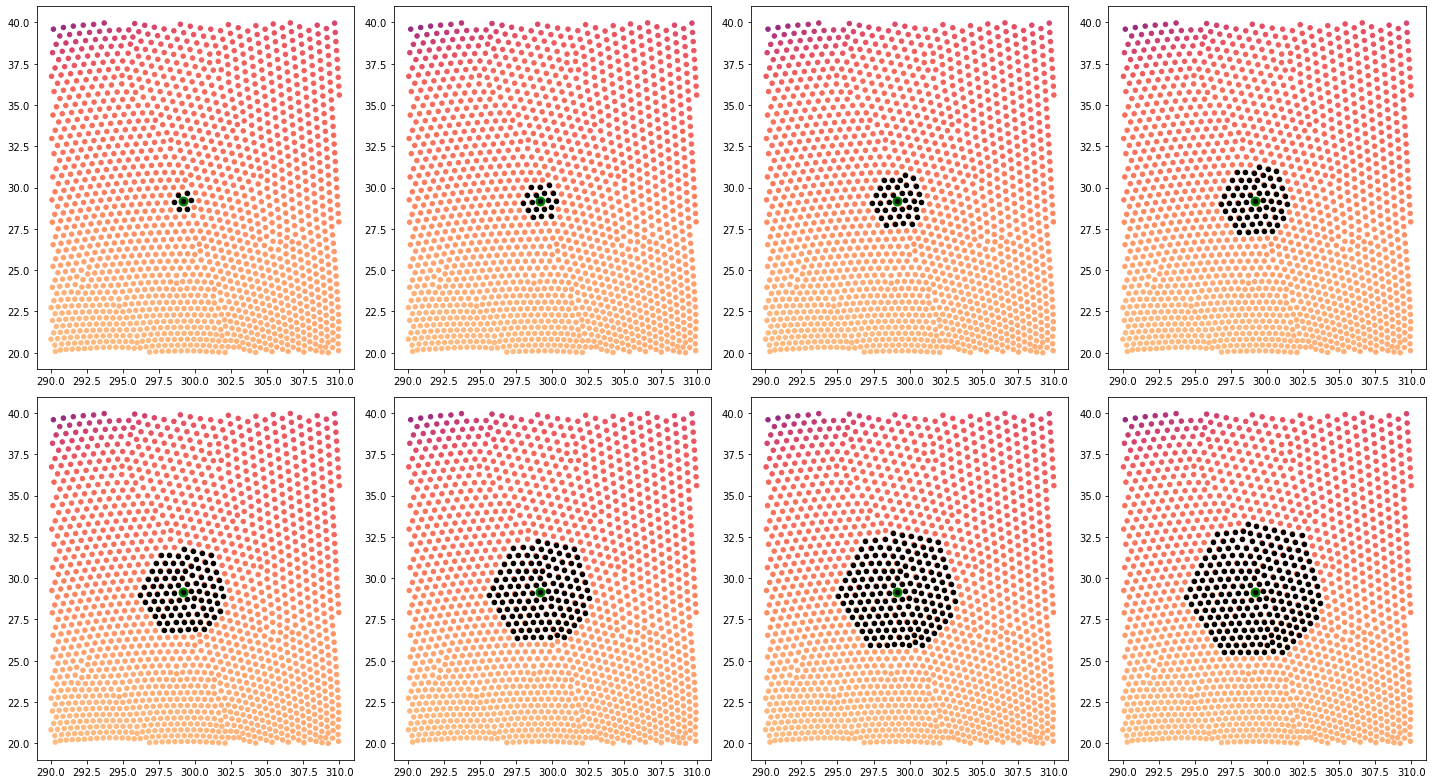

In [166]:
plt.figure(figsize=(20,11), tight_layout=True)


for i in range(number_of_dilations):
    plt.subplot(2,4,i+1)
    plt.scatter(londeg[indsLR],latdeg[indsLR],
                s=20,
                c=grid['temperature'][0,indsLR,0],
                cmap='magma',
                vmin=-5, vmax=31
               )
    plt.scatter(londeg[88747], latdeg[88747], c = 'g', s=80)
    plt.scatter(londeg[cdfac[i][88747]], latdeg[cdfac[i][88747]], c = 'k', s=20)
    

In [170]:
((6.5)**(1/3))*2*6.5

24.261322519312113